In [43]:
import numpy as np
import pandas as pd
from prophet import Prophet
import datetime as dt
import pprint
import yfinance as yf
import os
import itertools
import time

from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

In [44]:
class ProphetModel:
    def __init__(self, ticker):
        self.ticker = ticker
        self.today = dt.datetime.today().strftime('_%Y_%m_%d')


        self.model_add = Prophet(seasonality_mode='additive', 
                                daily_seasonality=True,         # daily seasonality
                                weekly_seasonality=True,        # weekly seasonality
                                yearly_seasonality=True,        # yearly seasonality
                                changepoint_prior_scale=0.2,    # strength of the trend changepoints
                                changepoint_range=0.95,         # proportion of history in which trend changepoints will be estimated
                                seasonality_prior_scale=1.0,   # strength of the seasonality model
                                holidays_prior_scale=0.01,
                                interval_width=0.95,            # width of the uncertainty intervals
                                uncertainty_samples=10000       # number of simulated draws used to estimate uncertainty intervals
                                )

        self.model_mult = Prophet(seasonality_mode='multiplicative',
                                daily_seasonality=True,
                                weekly_seasonality=True, 
                                yearly_seasonality=True, 
                                changepoint_prior_scale=0.2, 
                                changepoint_range=0.9, 
                                seasonality_prior_scale=1.0,
                                holidays_prior_scale=0.01,
                                interval_width=0.95,
                                uncertainty_samples=10000
                                )


        self.param_grid = {
            'seasonality_mode': ['additive'],
            'daily_seasonality': [True],
            'weekly_seasonality': [True],
            'yearly_seasonality': [True],
            'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.2],
            'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
            'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
            'changepoint_range': [0.8, 0.9, 0.95]
        }
        
    def get_data(self):
        data = yf.download(self.ticker, period='8y', interval='1d')
        data = data.reset_index()
        data = data.rename(columns={'Date': 'ds', 'Adj Close': 'y'})
        df = pd.DataFrame(data)
        return df


    def forecast_add(self):
        df = self.get_data()
        self.model_add.fit(df)
        future = self.model_add.make_future_dataframe(periods=30)
        forecast_add = self.model_add.predict(future)
        y_true = df["y"].values
        y_pred = forecast_add["yhat"].values[:-30]
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{self.ticker} {self.today} add MAE: {mae}")
        print(f"{self.ticker} {self.today} add MSE: {mse}")
        print(f"{self.ticker} {self.today} add R2: {r2}")

        forecast_df = forecast_add[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        actuals_df = df[['ds', 'y']].copy()
        merged_df = pd.merge(actuals_df, forecast_df, on='ds', how='outer')
        merged_df['yhat'] = merged_df['yhat'].fillna(merged_df['y'])
        merged_df['yhat_lower'] = merged_df['yhat_lower'].fillna(merged_df['y'])
        merged_df['yhat_upper'] = merged_df['yhat_upper'].fillna(merged_df['y'])
        merged_df = merged_df.set_index('ds')
        return forecast_add , merged_df


    def forecast_mult(self):
        df = self.get_data()
        self.model_mult.fit(df)
        future = self.model_mult.make_future_dataframe(periods=30)
        forecast_mult = self.model_mult.predict(future)
        y_true = df["y"].values
        y_pred = forecast_mult["yhat"].values[:-30]
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"{self.ticker} {self.today} mult MAE: {mae}")
        print(f"{self.ticker} {self.today} mult MSE: {mse}")
        print(f"{self.ticker} {self.today} mult R2: {r2}")
        return forecast_mult


    def plot_components(self, model, forecast, prefix):
        x = model.plot_components(forecast)    
        x.savefig(f'output_images/PROPHET/{self.ticker}/{self.ticker}_{prefix}_plot_components{self.today}.jpg')
        # return x

        
    def plot_forecast(self, model, forecast, prefix):
        x = model.plot(forecast)
        if os.path.exists(f'output_images/PROPHET/{self.ticker}'):
            x.savefig(f'output_images/PROPHET/{self.ticker}/{self.ticker}_{prefix}_plot_forecast{self.today}.jpg')
        else:
            os.mkdir(f'output_images/PROPHET/{self.ticker}')
            x.savefig(f'output_images/PROPHET/{self.ticker}/{self.ticker}_{prefix}_plot_forecast{self.today}.jpg')
        # return x   

    
    def cross_validate(self):
        df = self.get_data()
        cv_results_add = cross_validation(self.model_add, initial='365 days', period='30 days', horizon = '7 days', parallel='processes')
        cv_results_mult = cross_validation(self.model_mult, initial='365 days', period='30 days', horizon = '7 days', parallel='processes')
        return cv_results_add, cv_results_mult  

    def hyperparameter_tuning(self):
        df = self.get_data()
        param_grid = ParameterGrid(self.param_grid)
        results = []
        for params in param_grid:
            model = Prophet(**params)
            model.fit(df)
            future = model.make_future_dataframe(periods=30)
            forecast = model.predict(future)
            y_true = df["y"].values
            y_pred = forecast["yhat"].values[:-30]
            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            results.append((params, mae, mse, r2))
        return results

    def write_to_csv(self,pm_add,pm_mult, prefix):
        df = self.get_data()
        df.to_csv(f'output_data/PROPHET/{self.ticker}/{self.ticker}_{prefix}_output{self.today}.csv')
        pm_mult.to_csv(f'output_data/PROPHET/{self.ticker}/{self.ticker}_{prefix}_mult{self.today}.csv')
        pm_add.to_csv(f'output_data/PROPHET/{self.ticker}/{self.ticker}_{prefix}_add{self.today}.csv')
        return df 



In [45]:
tickerList = ['AAPL', 'AMD', 'VALE', 'AMZN', 'F', 'GM', 'TM', 'TSLA']

In [46]:
# remove future warnings from prophet
import warnings


In [47]:
warnings.simplefilter(action='ignore', category=FutureWarning)

[*********************100%***********************]  1 of 1 completed
AAPL _2023_02_04 add MAE: 3.1299144705268866
AAPL _2023_02_04 add MSE: 18.79612816882743
AAPL _2023_02_04 add R2: 0.9924027441505993
[*********************100%***********************]  1 of 1 completed
AAPL _2023_02_04 mult MAE: 2.674175888164269
AAPL _2023_02_04 mult MSE: 13.403119953328906
AAPL _2023_02_04 mult R2: 0.9945825581613139
[*********************100%***********************]  1 of 1 completed
AMD _2023_02_04 add MAE: 3.6829360566602487
AMD _2023_02_04 add MSE: 29.014366318398828
AMD _2023_02_04 add R2: 0.9811539090565914
[*********************100%***********************]  1 of 1 completed
AMD _2023_02_04 mult MAE: 2.7365204734130457
AMD _2023_02_04 mult MSE: 18.579562987239555
AMD _2023_02_04 mult R2: 0.9879317669769592
[*********************100%***********************]  1 of 1 completed
VALE _2023_02_04 add MAE: 0.5943484709073181
VALE _2023_02_04 add MSE: 0.6350616718725114
VALE _2023_02_04 add R2: 0.9687

FileNotFoundError: [Errno 2] No such file or directory: 'output_images/PROPHET/VALE/VALE_add_plot_components_2023_02_04.jpg'

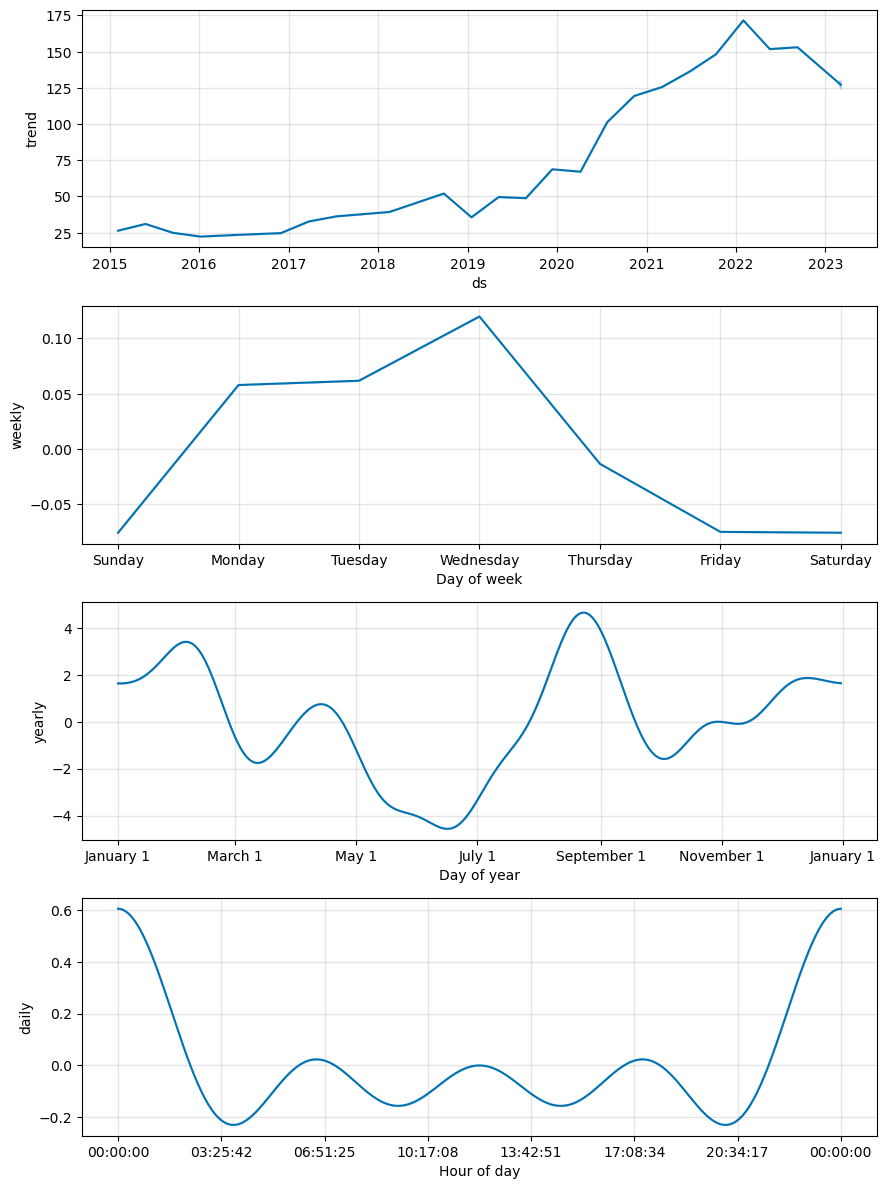

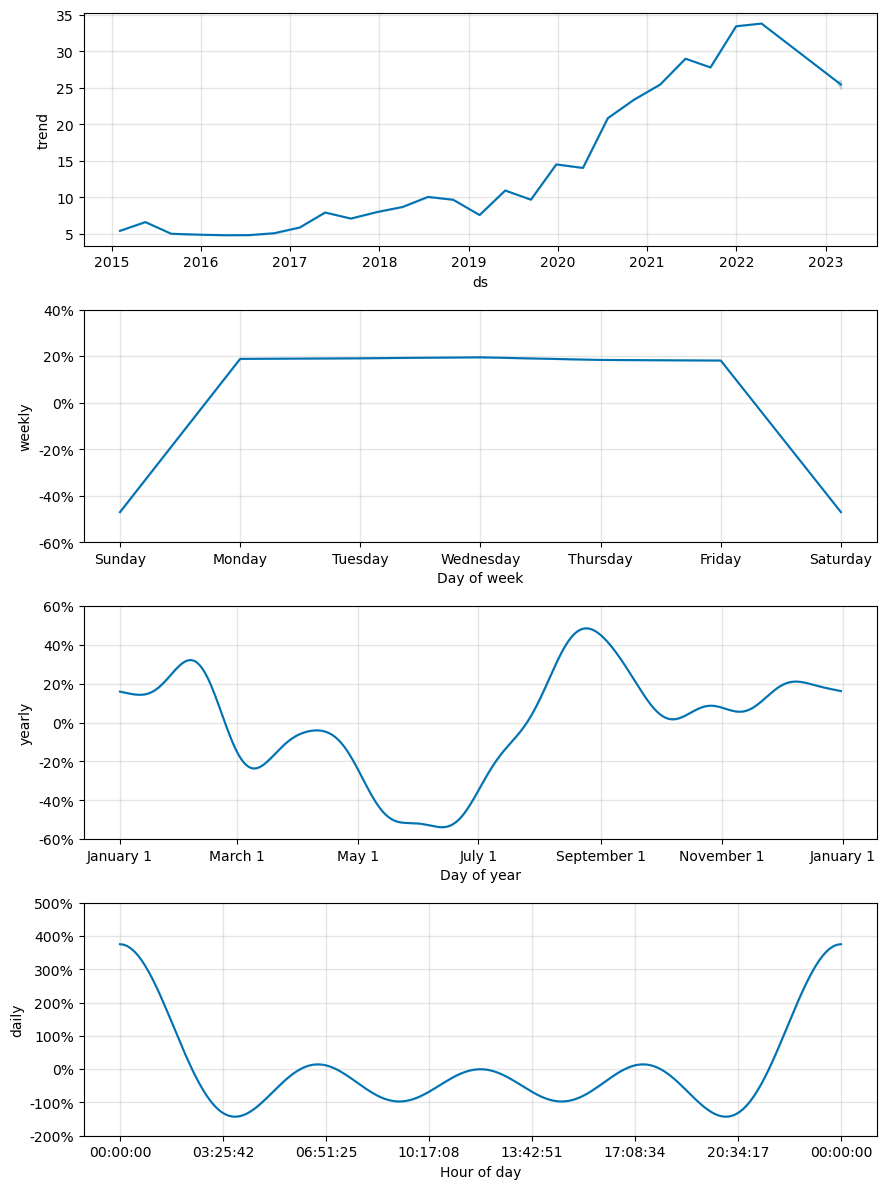

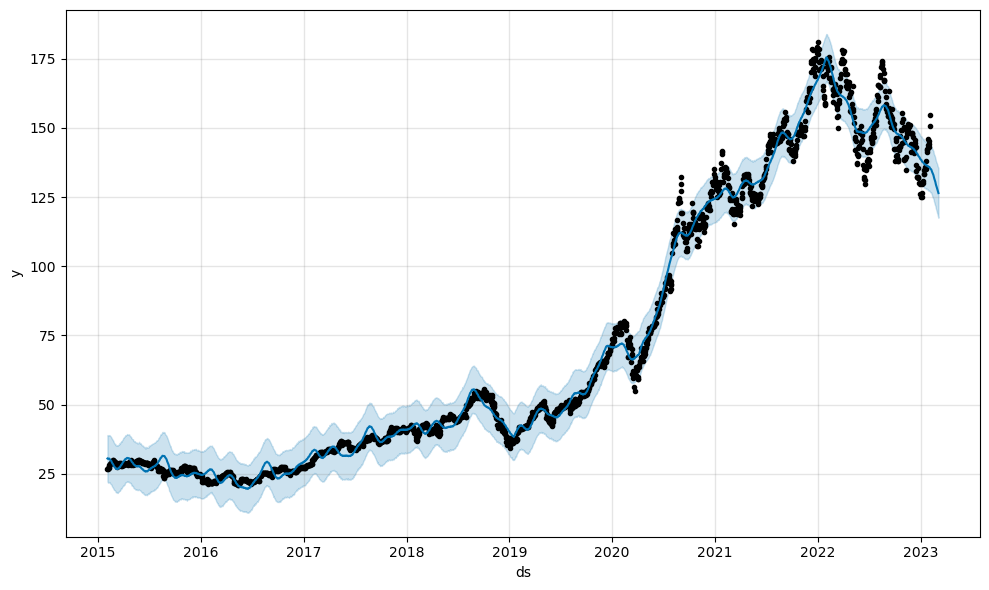

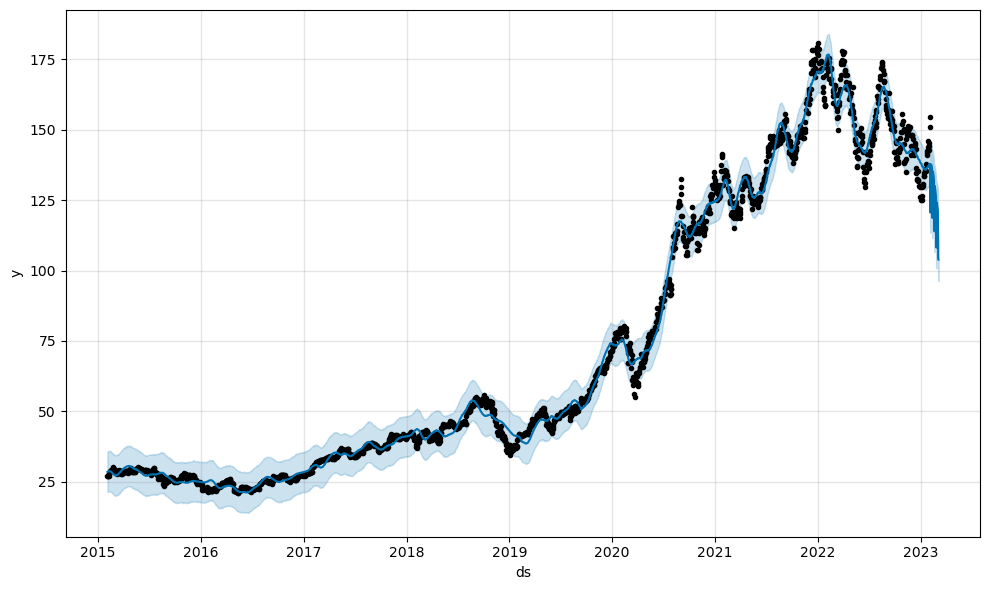

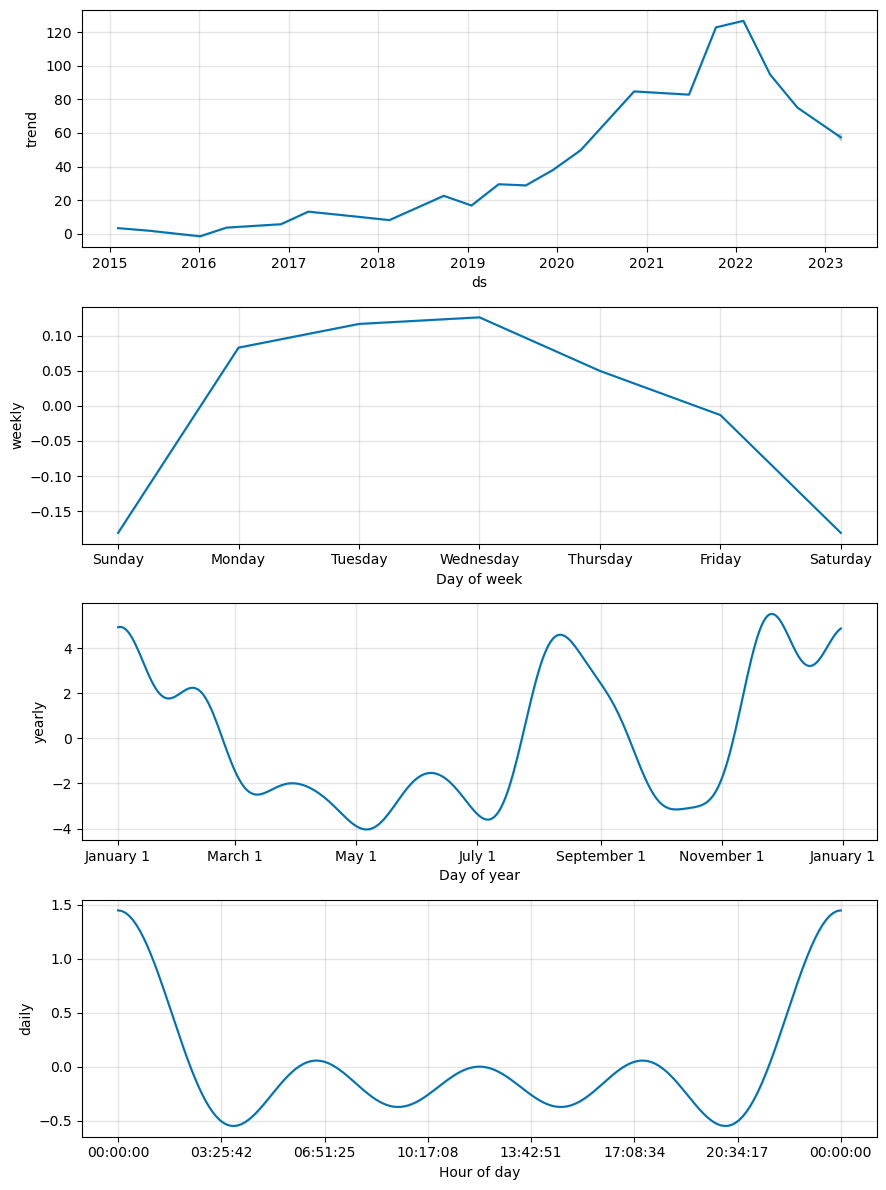

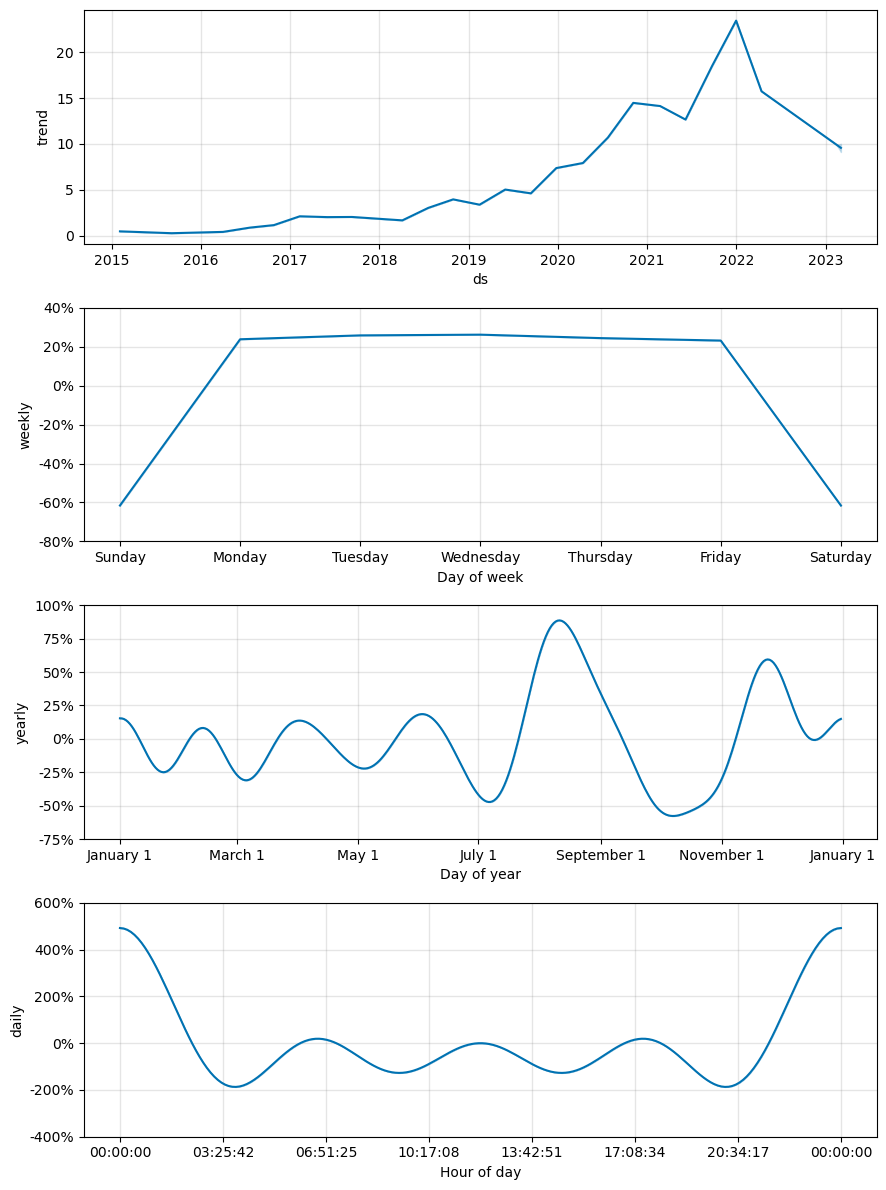

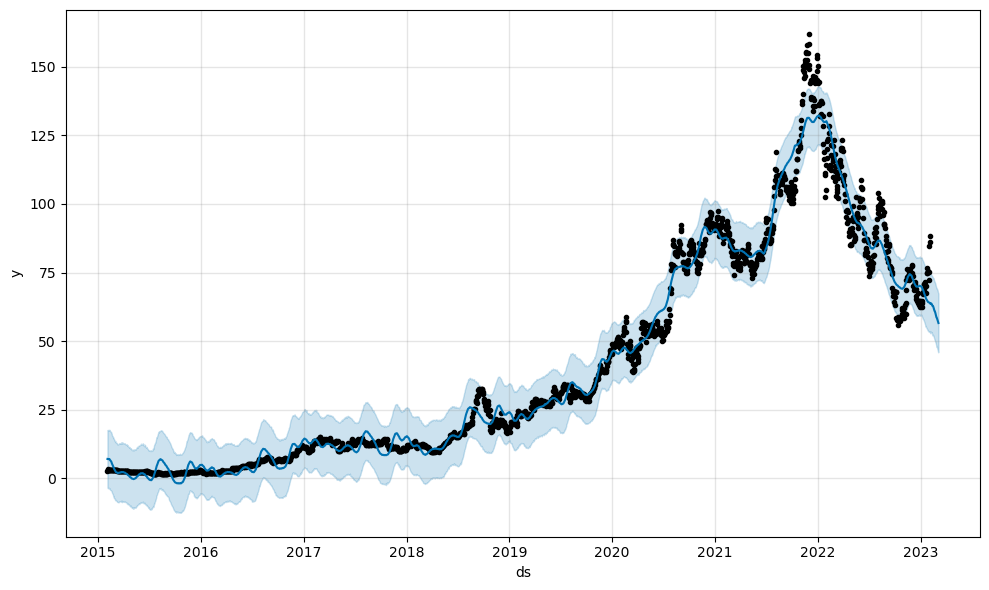

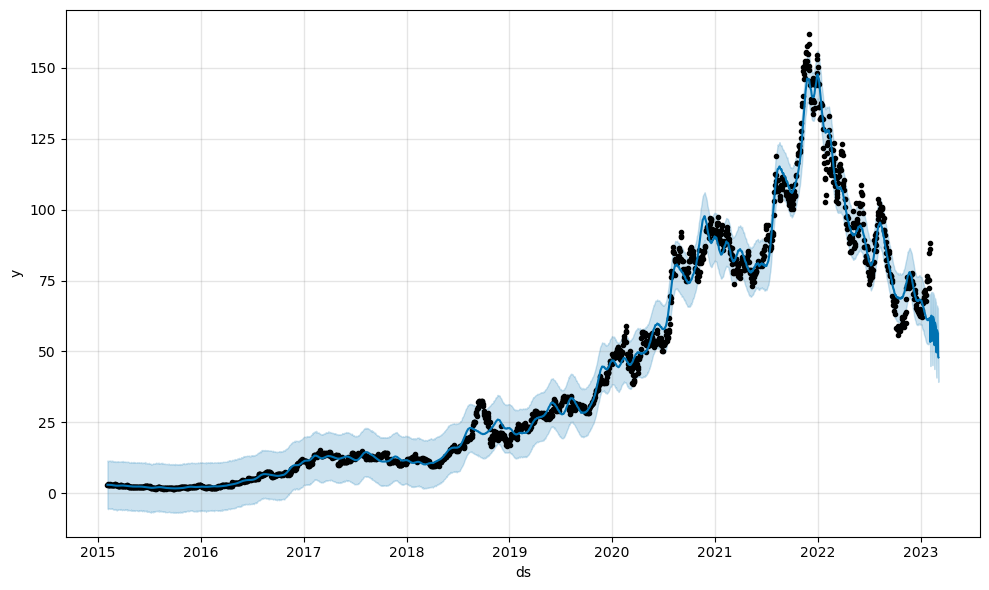

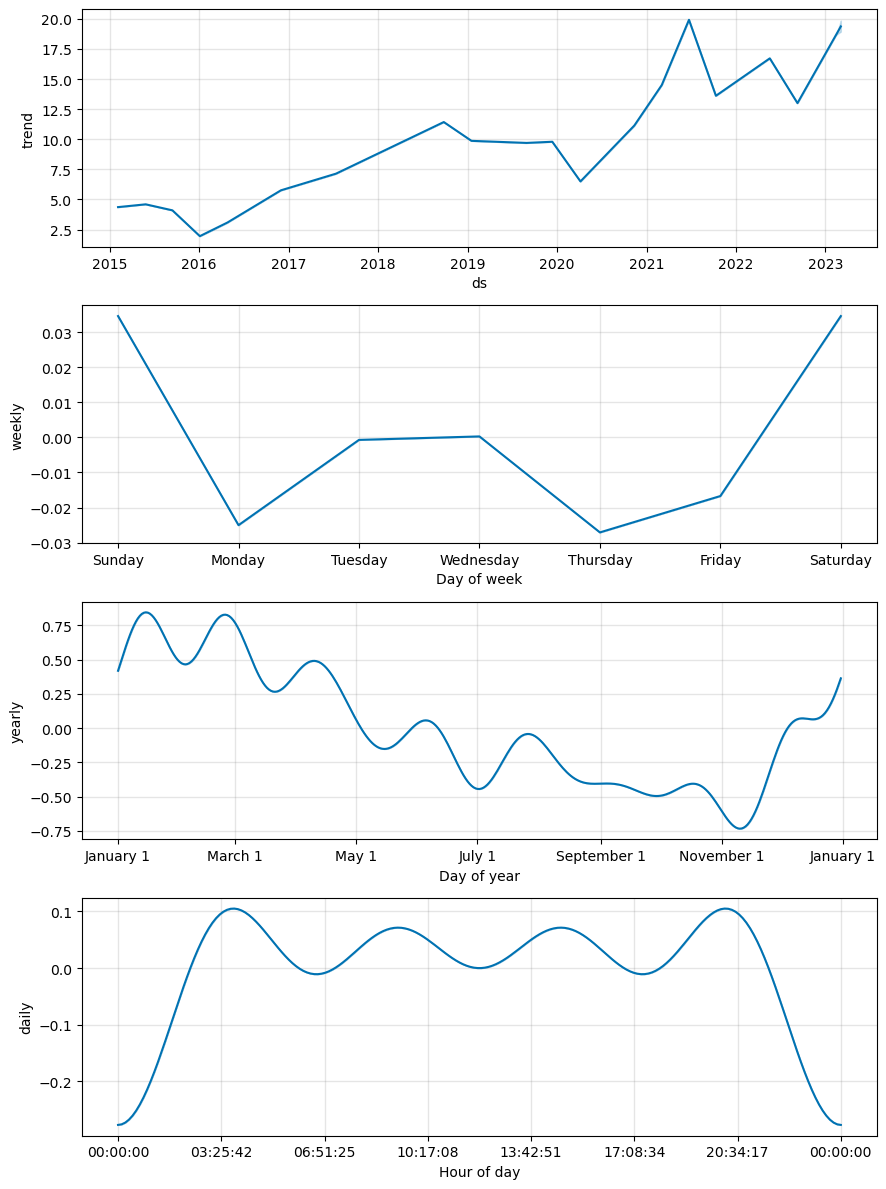

In [48]:
for ticker in tickerList:
    del model
    model = ProphetModel(ticker)
    add_forecast, merged_df_add = model.forecast_add()
    mult_forecast = model.forecast_mult()
    model.plot_components(model.model_add, add_forecast, 'add')
    model.plot_components(model.model_mult, mult_forecast, 'mult')
    model.plot_forecast(model.model_add, add_forecast, 'add')
    model.plot_forecast(model.model_mult, mult_forecast, 'mult')

In [ ]:
ticker = "TSLA"
# forecaster = ProphetModel(ticker.upper())

In [ ]:
forecast_add, df = forecaster.forecast_add()
forecast_mult = forecaster.forecast_mult()


[*********************100%***********************]  1 of 1 completed


c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


add MAE: 10.280128476145363
add MSE: 270.3785025875263
add R2: 0.976978547715115
[*********************100%***********************]  1 of 1 completed


c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


mult MAE: 5.97684392672172
mult MSE: 120.50200586338859
mult R2: 0.9897398234265355


In [ ]:
# takes 7 min and 100% cpu
cv_results_add, cv_results_mult = forecaster.cross_validate()

[*********************100%***********************]  1 of 1 completed

INFO:prophet:Making 85 forecasts with cutoffs between 2016-03-02 00:00:00 and 2023-01-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021C971523D0>


INFO:prophet:Making 85 forecasts with cutoffs between 2016-03-02 00:00:00 and 2023-01-25 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000021C97112A90>


In [ ]:
pm_mult = performance_metrics(cv_results_mult)

In [ ]:
pm_mult

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,578.329020,24.048472,12.037818,0.090149,0.056949,0.089254,0.576271
1,2 days,578.870606,24.059730,12.355738,0.095302,0.064435,0.095035,0.442623
2,3 days,446.055182,21.120019,11.348356,0.090158,0.068208,0.089557,0.464286
3,4 days,696.246989,26.386493,12.380488,0.100186,0.074835,0.097903,0.448276
4,5 days,1012.860438,31.825468,14.793821,0.110966,0.069159,0.109666,0.413793
5,6 days,1202.364311,34.675125,16.509436,0.119267,0.069159,0.116413,0.416667
6,7 days,1355.711797,36.819992,18.020643,0.142012,0.079277,0.135378,0.333333


In [ ]:
#performance_metrics(cv_results)
pm_add = performance_metrics(cv_results_add)


In [ ]:
pm_add

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,536.258120,23.157248,12.659406,0.100893,0.063228,0.100595,0.576271
1,2 days,724.777178,26.921686,14.195792,0.114214,0.082823,0.111875,0.459016
2,3 days,679.217807,26.061807,13.566204,0.103354,0.082031,0.102874,0.446429
3,4 days,736.406672,27.136814,13.992029,0.108024,0.090153,0.107129,0.482759
4,5 days,532.487205,23.075684,12.568606,0.108592,0.068596,0.105476,0.500000
5,6 days,530.882122,23.040879,13.321183,0.116926,0.087426,0.112959,0.416667
6,7 days,657.844063,25.648471,15.056301,0.138669,0.105338,0.132112,0.350877


In [ ]:
#forecaster.write_to_csv(pm_add,pm_mult, "data")

c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\xande\a

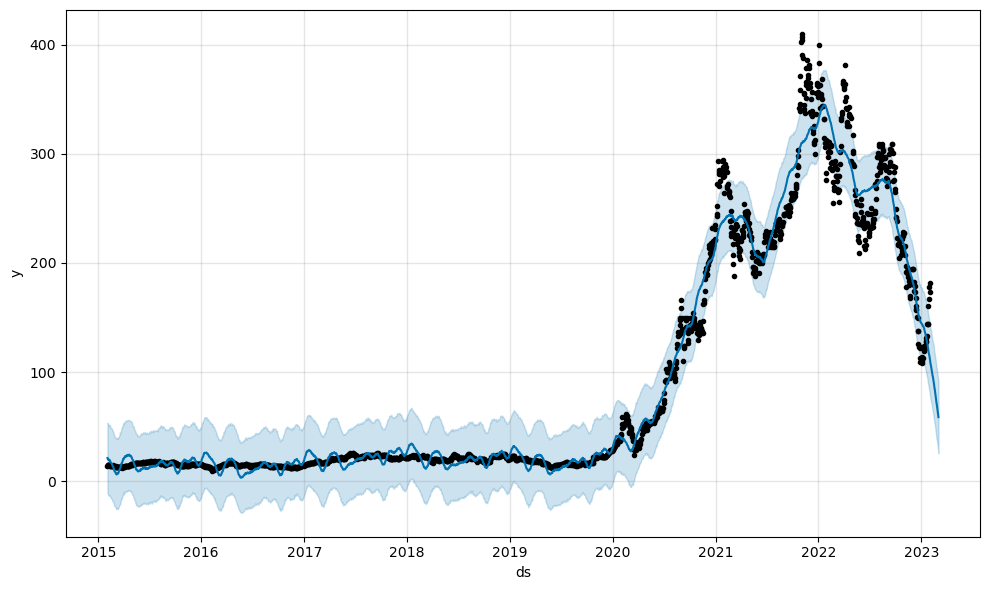

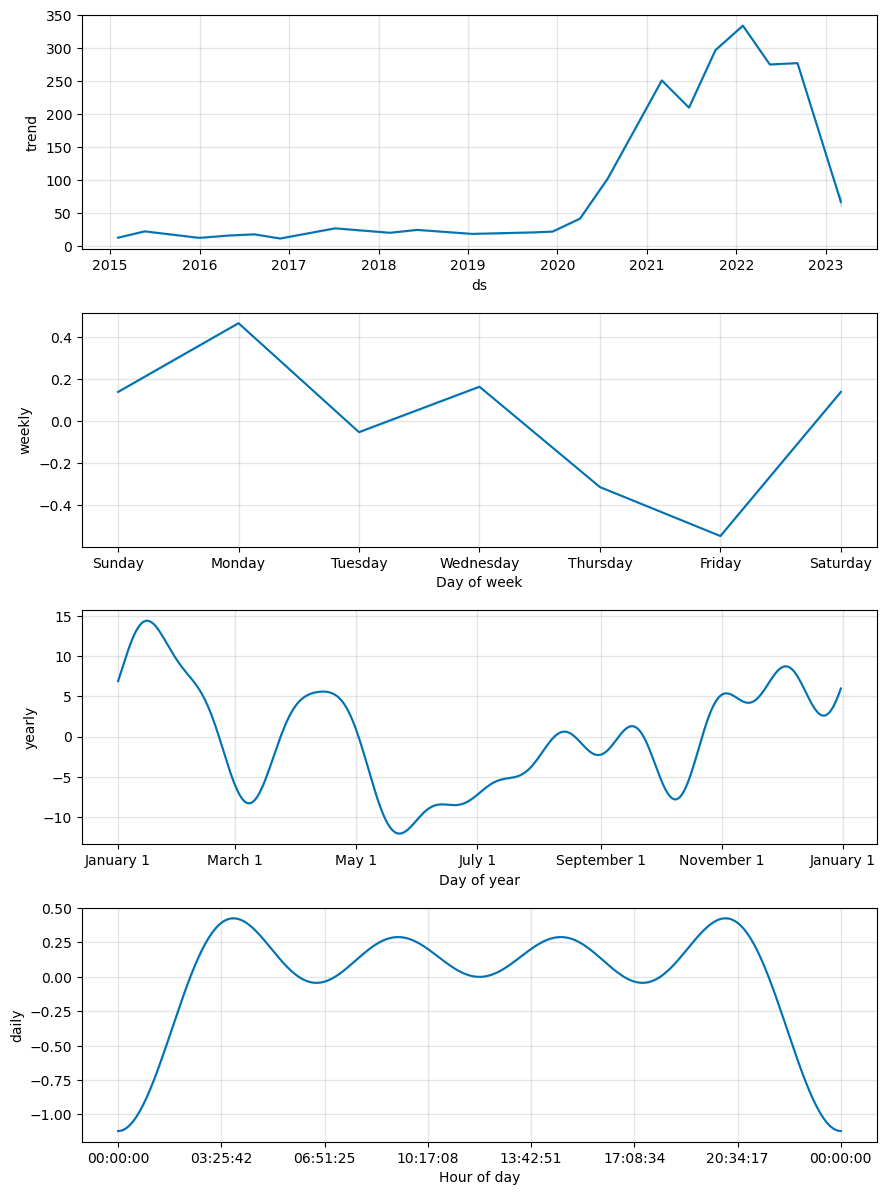

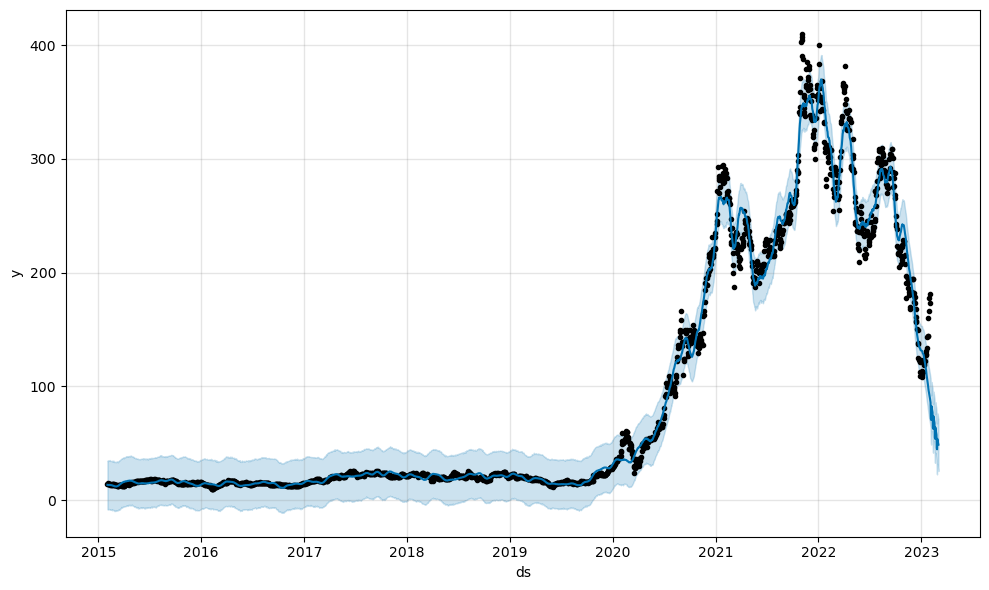

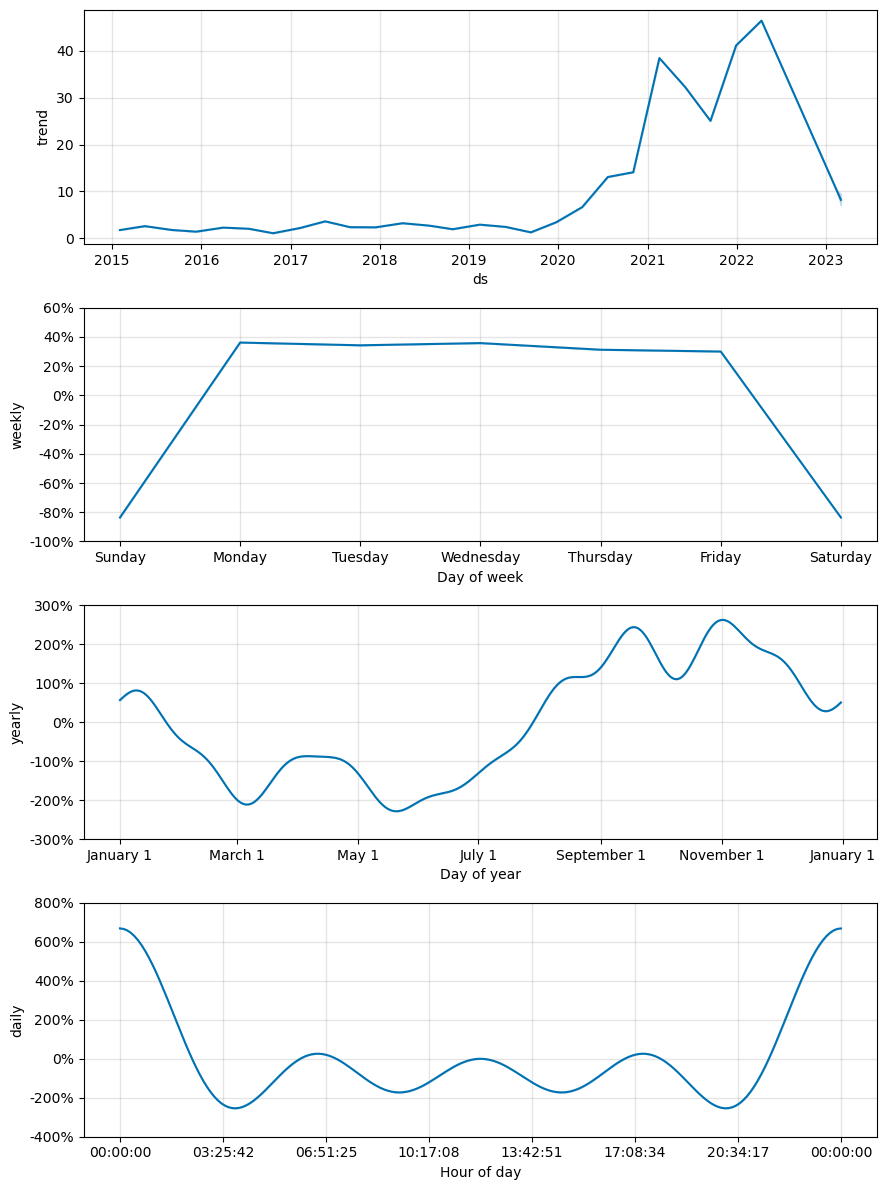

In [ ]:
# loop to plot all the components of the model for both additive and multiplicative
for i in ['add', 'mult']:
    if i == 'add':
        model = forecaster.model_add
        forecast = forecast_add
        prefix = 'additive'
    else:
        model = forecaster.model_mult
        forecast = forecast_mult
        prefix = 'multiplicative'
    forecaster.plot_forecast(model, forecast, prefix)
    forecaster.plot_components(model, forecast, prefix)
    


In [ ]:
# test hyperparameter tuning 
# takes 1 hour and 100% cpu
# results = forecaster.hyperparameter_tuning()
# results

In [ ]:
# results = pd.DataFrame(results, columns=['params', 'mae', 'mse', 'r2'])
# results = results.sort_values(by='r2', ascending=False).head()

# results

# # find 5 best models and plot them
# best_models = results.sort_values(by='r2', ascending=True).head(5)
# best_models
# print params of best models
# for index, row in best_models.iterrows():
#     print(row['params'])
#     print("")

In [ ]:
df = df.tail(45)
df = df.head(25)
print(df.to_markdown())

| ds                  |      y |     yhat |   yhat_lower |   yhat_upper |
|:--------------------|-------:|---------:|-------------:|-------------:|
| 2023-01-11 00:00:00 | 123.22 | 140.1    |     108.446  |      172.292 |
| 2023-01-12 00:00:00 | 123.56 | 138.822  |     107.679  |      171.12  |
| 2023-01-13 00:00:00 | 122.4  | 137.704  |     105.747  |      169.965 |
| 2023-01-17 00:00:00 | 131.49 | 133.816  |     101.05   |      165.615 |
| 2023-01-18 00:00:00 | 128.78 | 132.737  |     100.87   |      165.53  |
| 2023-01-19 00:00:00 | 127.17 | 130.893  |      98.4635 |      162.736 |
| 2023-01-20 00:00:00 | 133.42 | 129.232  |      97.668  |      161.661 |
| 2023-01-23 00:00:00 | 143.75 | 125.683  |      93.6321 |      157.709 |
| 2023-01-24 00:00:00 | 143.89 | 123.577  |      91.0482 |      156.23  |
| 2023-01-25 00:00:00 | 144.43 | 122.19   |      89.7911 |      153.93  |
| 2023-01-26 00:00:00 | 160.27 | 120.099  |      88.7405 |      152.566 |
| 2023-01-27 00:00:00 | 177.9  | 118.2